# Statistical analysis illustrating the use of the Bike Sampa system

## This notebook answers the following questions:

### - How many trips occurred through the years?
### - What is the average distance rode by users?
### - How long do the trips last?
### - What is the average age of users?
### - What is the average speed of women and men?

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.dates as mdate
from shapely.geometry import Point
import geopandas as gpd
import folium
import math
import datetime as dt
import glob
from ipywidgets import interact_manual, widgets
from scipy.interpolate import CubicSpline
import seaborn as sbn
import warnings

import bikescience.charts as ch
import tembici.load_trips as load
import tembici.stations as tst
import bikescience.distributions as dist
from IPython.core.display import display, HTML

pd.set_option('display.float_format', lambda x: '%.1f' % x)
# global settings for the charts
plt.rcParams['font.family'] = 'FreeSerif'
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 18
warnings.simplefilter('ignore')

## Loading all Bike Sampa trips from Jan 2018 to Jun 2019

In [2]:
trips = load.load_trips_files('../../../tembici/trips_*.csv')
display(HTML('<div class=\"custom\"><h3>%s trips</h3>'%(len(trips))))

In [3]:
stations = pd.read_csv('../../../tembici/Estações_Tembici_fev2019.csv')
stations = stations[stations.project == 'BikeSampa']
stations = tst.stations_geodf(stations)
display(HTML('<div class=\"custom\"><h3>%s stations in São Paulo</h3>'%(len(stations))))

## Age distribution

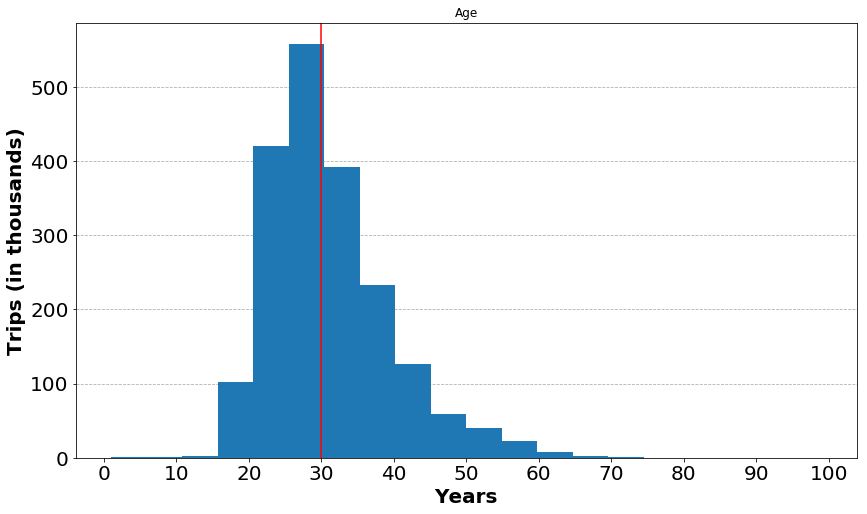

In [4]:
tage = trips[~trips["birth year"].isnull()]
tage = tage["starttime"].dt.year - tage["birth year"]
tage = tage[(tage > 0) & (tage < 100)]

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=10)
ax_age = plt.axes()
ax_age.set_axisbelow(True)
plt.grid(linestyle='--')
ax_age.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_age.yaxis.set_major_formatter(formatter)
ax_age.xaxis.set_major_locator(loc)
plt.hist(bins=20,x=tage)
plt.axvline(x=tage.median(),color='red')
plt.title('Age')
plt.xlabel('Years')
plt.ylabel('Trips (in thousands)')
plt.show()

##   Trip duration distribution

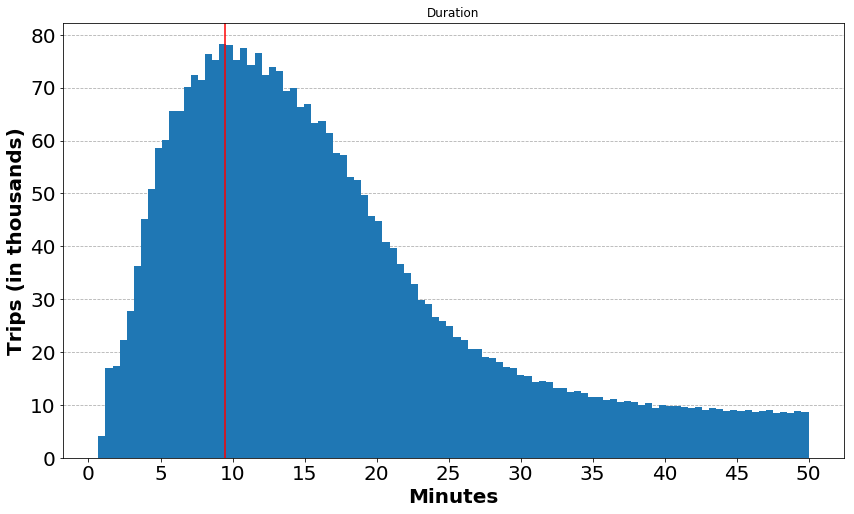

In [5]:
duration = trips[trips['tripduration'] < 3000]
duration = duration[['tripduration']]

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=5)

ax_duration = plt.axes()
ax_duration.set_axisbelow(True)
plt.grid(linestyle='--')
ax_duration.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_duration.yaxis.set_major_formatter(formatter)
ax_duration.xaxis.set_major_locator(loc)
plt.hist(bins=100,x=duration['tripduration']/60)
plt.title('Duration')
plt.xlabel('Minutes')
plt.ylabel('Trips (in thousands)')
#fig_duration = plt.gcf()
plt.axvline(x=9.5,color='red')
plt.show()

## User type

In [6]:
subscribers = trips[trips['usertype'] == 'Subscriber']
customers = trips[trips['usertype'] == 'Customer']
display(HTML('<div class=\"custom\"><h3>Subscriber: %s (%s)</h3>'%("{0:.2%}".format(len(subscribers) / len(trips)),len(subscribers))))
display(HTML('<div class=\"custom\"><h3>Customer: %s (%s)</h3>'%("{0:.2%}".format(len(customers) / len(trips)),len(customers))))

## Gender distribution

In [8]:
male = trips[trips['gender'] == 'Masc']
female = trips[trips['gender'] == 'Fem']
unknown = trips[(trips['gender'] == 'Null')|(trips['gender'].isnull())]
display(HTML('<div class=\"custom\"><h3>Male: %s (%s)</h3>'%("{0:.2%}".format(len(male) / len(trips)),len(male))))
display(HTML('<div class=\"custom\"><h3>Female: %s (%s)</h3>'%("{0:.2%}".format(len(female) / len(trips)),len(female))))
display(HTML('<div class=\"custom\"><h3>Unknown: %s (%s)</h3>'%("{0:.2%}".format(len(unknown) / len(trips)),len(unknown))))

## Distance

Using the GraphHoper algorithm

In [9]:
stations = pd.read_csv('../../../tembici/Estações_Tembici_fev2019.csv')
stations = stations[stations.project == 'BikeSampa']
stations.reset_index(inplace=True)

stations_distances = pd.read_csv('../../data/sao-paulo/bike-stations/stations_distances.csv')
stations_distances.columns = ['distance', 'index_start', 'index_end']

station_ids = stations[['name', 'index']]

station_ids.columns = ['start_station_name', 'index']
merge = trips.merge(station_ids, on='start_station_name')

station_ids.columns = ['end_station_name', 'index']
merge = merge.merge(station_ids, on='end_station_name', suffixes=('_start', '_end'))

merge = merge.merge(stations_distances, on=['index_start', 'index_end'])
merge['speed'] = merge['distance']/merge['tripduration']*3600

### Trip distance profile (ignoring round-trips)

In [10]:
distance = merge[(merge.distance<10) & (merge.distance>0)]

distance = distance[['distance']]

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=1)

ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
formatter = tkr.FuncFormatter(ch.numbers_in_thousands)
ax_distance.yaxis.set_major_formatter(formatter)
ax_distance.xaxis.set_major_locator(loc)
plt.hist(bins=16,x=distance['distance'])
plt.title('Distance')
plt.xlabel('Kilometers')
plt.ylabel('Trips (in thousands)')
plt.axvline(x=distance['distance'].median(),color='red')
#fig_distance = plt.gcf()
plt.show()

In [10]:
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
#distance['distance'].describe()

## Speed: Women are a little less in a hurry :-)


In [11]:
gender = merge
gender = gender[gender.distance < 50]
gender.reset_index(inplace=True)
gender = gender[['gender','distance','tripduration','speed']]


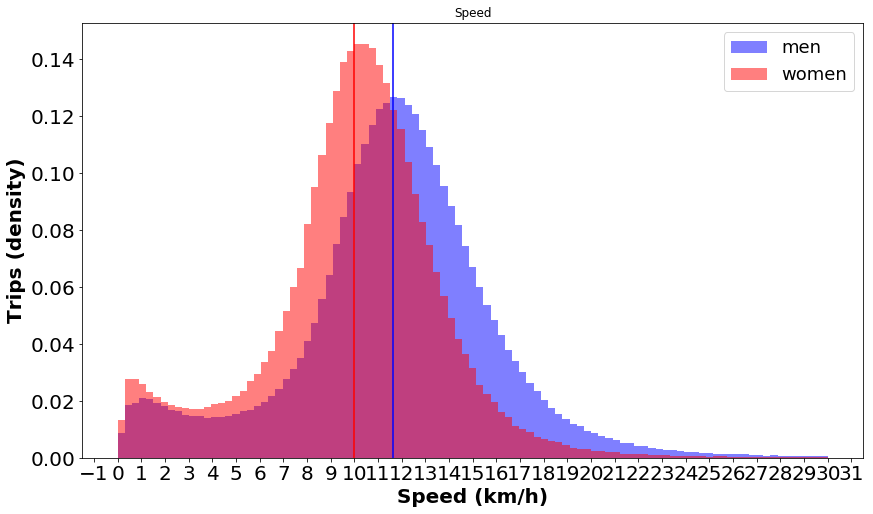

In [12]:
women_speed = gender[(gender.gender == 'Fem') & (gender.speed> 0) & (gender.speed < 30)].speed
men_speed   = gender[(gender.gender == 'Masc') & (gender.speed> 0) & (gender.speed < 30)].speed

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=1)

bins = np.linspace(0, 30, 100)
ax_gender = plt.axes()
ax_gender.xaxis.grid(False)
ax_gender.yaxis.grid(False)
ax_gender.xaxis.set_major_locator(loc)
plt.hist(men_speed, bins, alpha=0.5, label='men', density=True, color='blue')
plt.hist(women_speed, bins, alpha=0.5, label='women', density=True, color='red')
plt.legend(loc='upper right')
plt.title('Speed')
plt.axvline(x=women_speed.mean(),color='red')
plt.axvline(x=men_speed.mean(),color='blue')
plt.xlabel('Speed (km/h)')
plt.ylabel('Trips (density)')
plt.show()

In [13]:
#boxplots
plt.figure(figsize=(10,6))
plt.xlabel('Gender')
plt.ylabel('Speed (km/h)')
plt.boxplot([women_speed,men_speed],showfliers=False)
plt.xticks([1,2],['Female','Male'])
pos=[1,2]

### Trips per month and gender - day usage average, and standard deviation from Jan 2018 to Jun 2019

In [15]:
trip_time_series = trips[['starttime', 'gender']]
trip_time_series = \
        trip_time_series[(trip_time_series.starttime < pd.Timestamp('2020-01-01 00:00:0000'))]
trip_time_series.set_index(pd.DatetimeIndex(trip_time_series['starttime']), inplace=True)

### Getting the daily average per month

In [16]:
trips_day_average = trip_time_series['starttime'].groupby(pd.Grouper(freq='D')).count()
trips_per_month = trips_day_average.groupby(pd.Grouper(freq='MS')).agg({'mean':'mean','std':'std'})

### Percentage of women trips

In [18]:
#women bike usage percentage
women_trips = trip_time_series[(trip_time_series.gender == 'Fem')]
men_trips = trip_time_series[(trip_time_series.gender == 'Masc')]

women_trips_day_count = women_trips['starttime'].groupby(pd.Grouper(freq='D')).count()
men_trips_day_count = men_trips['starttime'].groupby(pd.Grouper(freq='D')).count()

women_trips_per_month = women_trips_day_count.groupby(pd.Grouper(freq='MS')).agg({'sum':'sum'})
men_trips_per_month = men_trips_day_count.groupby(pd.Grouper(freq='MS')).agg({'sum':'sum'})

women_percentage_per_month = women_trips_per_month.copy()
men_percentage_per_month = men_trips_per_month.copy()

women_percentage_per_month['percentage'] = \
    women_percentage_per_month['sum']/(women_percentage_per_month['sum']+men_percentage_per_month['sum'])*100

In [19]:
#filling the missing month 2019-03-01 using the average of the previous and following months
trips_per_month.at['2019-03-01','mean'] = (trips_per_month.loc['2019-02-01','mean'] + trips_per_month.loc['2019-04-01','mean'])/2
trips_per_month.at['2019-03-01','std'] = (trips_per_month.loc['2019-02-01','std'] + trips_per_month.loc['2019-04-01','std'])/2

women_percentage_per_month.at['2019-03-01','sum'] = (women_percentage_per_month.loc['2019-02-01','sum'] + women_percentage_per_month.loc['2019-04-01','sum'])/2
women_percentage_per_month.at['2019-03-01','percentage'] = (women_percentage_per_month.loc['2019-02-01','percentage'] + women_percentage_per_month.loc['2019-04-01','percentage'])/2


### Time series - Trips 

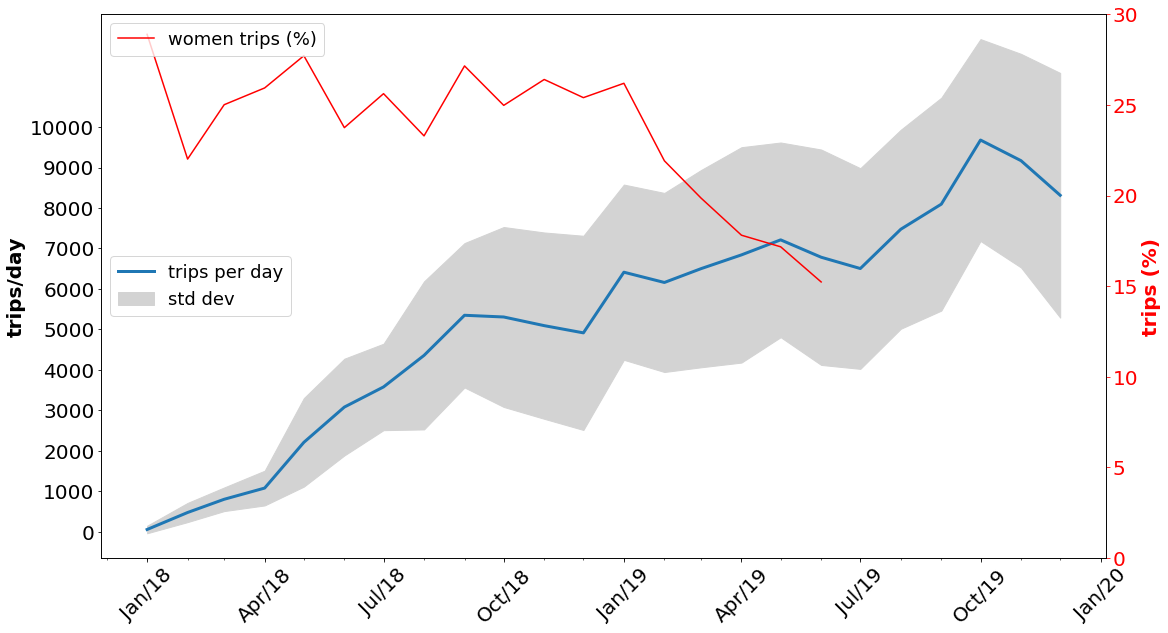

In [20]:
dateFmt = mdate.DateFormatter('%b/%y')

ax_day_avg_gender = plt.axes()
ax_day_avg_gender.set_axisbelow(True)
ax_day_avg_gender.xaxis.grid(False)
ax_day_avg_gender.yaxis.grid(False)
ax_day_avg_gender.plot(trips_per_month['mean'], label='trips per day', linewidth=3)
ax_day_avg_gender.figure.set_size_inches(18,10)
ax_day_avg_gender.xaxis.set_major_formatter(dateFmt)
ax_day_avg_gender.xaxis.set_minor_locator(mdate.MonthLocator())

plt.ylabel('trips/day')
plt.xticks(rotation=45)
plt.yticks(np.arange(0,10001,step=1000))
plt.fill_between(trips_per_month.index,trips_per_month['mean']-trips_per_month['std'],
                 trips_per_month['mean']+trips_per_month['std'],color='lightgray',label='std dev')
plt.legend(loc='center left')

ax_perc_women = ax_day_avg_gender.twinx()
ax_perc_women.plot(women_percentage_per_month.index,women_percentage_per_month['percentage'],label='women trips (%)',color='red')
ax_perc_women.set_ylabel('trips (%)', color='red')
ax_perc_women.yaxis.grid(False)
ax_perc_women.xaxis.set_major_formatter(dateFmt)
ax_perc_women.set_yticks(np.arange(0,30.1,step=5))
ax_perc_women.legend(loc='upper left')
ax_perc_women.tick_params('y',colors='red')

plt.savefig('charts/Trips-Evolution.pdf', format='pdf', dpi=200)
plt.draw()

## Beware of dangerous cyclists
### Trips with more than 25km/h average speed
### There're are a lot of them in the 25-30 age range; but, in fact they might occur in all ages.

In [21]:
speeders = merge[merge.speed >25]
#speeders.head()

In [22]:
t = merge[~merge["birth year"].isnull()]
t["birth year"] = t["birth year"].astype(int)
t["age"] = 2018 - t["birth year"]
speeders = t[t.speed >25].age
normal  = t.age

plt.figure(figsize=(14,8))
loc = tkr.MultipleLocator(base=5)

bins = np.linspace(10, 70, 30)
plt.hist(speeders, bins, alpha=0.5, label='speeders', density=True, color='blue')
plt.hist(normal, bins, alpha=0.5, label='normal', density=True, color='red')
#plt.xaxis.set_major_locator(loc)
plt.axvline(x=speeders.mean(),color='blue')
plt.axvline(x=normal.mean(),color='red')
plt.xlabel('Age')
plt.ylabel('Frequency (%)')
plt.legend(loc='upper right')
plt.show()

## Trip daily pattern per station

In [23]:
def trip_daily_pattern(station, trip_point):
    print('Calculating...')
    station_id = stations[stations['name'] == station].index[0]
    day_counts = merge[merge['index_' + trip_point] == station_id] \
          [['hour', 'weekend', 'per_day']].drop_duplicates() \
          .groupby(['hour', 'weekend'], as_index=False).agg({'per_day': 'count'})
    trip_counts = merge[merge['index_' + trip_point] == station_id] \
                .groupby(['hour', 'weekend'], as_index=False).agg({'tripduration': 'count'})
    counts = day_counts.merge(trip_counts, on=['hour', 'weekend'])
    counts.rename(columns={'per_day': 'day_count', 'tripduration': 'trip_count'}, inplace=True)
    counts['daily_mean'] = counts['trip_count'] / counts['day_count']
    
    plt.figure(figsize=(20, 8))
    width=0.5
        
    for t in [False, True]:
        filtered = counts[counts['weekend'] == t]
        y = filtered['daily_mean']
        x = filtered['hour']
        if len(x) > 0:
            plt.bar(x-width/2 if t else x+width/4, y, width=width, label='weekend' if t else 'working day')
        if len(x) >= 2:  # mininum for spline generation
            spline = CubicSpline(x, y)
            x_vals = np.linspace(x.min(), x.max(), 500, dtype=np.float64)
            y_smooth = spline(x_vals)
            plt.plot(x_vals, y_smooth)
        
    plt.xlabel('Hour')
    plt.ylabel('Daily mean')
    plt.legend()
    print('Done.')
    plt.show()
    
im = interact_manual(
    trip_daily_pattern,
    station=widgets.Dropdown(options=stations['name'].sort_values(), value='1 - Largo da Batata'),
    trip_point=widgets.RadioButtons(options=['start', 'end'])
)
im.widget.children[2].description = 'Show chart' 

interactive(children=(Dropdown(description='station', options=('1 - Largo da Batata', '10 - Rua Campo Verde', …

## Trips per station

Counting trips:

In [24]:
#trips
trips_by_day = trips.groupby(['start_station_name'], as_index=False).agg({'tripduration': 'count'})
trips_by_day.columns = ['start_station_name', 'trip count']
trips_by_day.set_index('start_station_name',inplace=True)
trips_by_day.sort_values('trip count', ascending=False).head(10)

trip count
start_station_name                             
1 - Largo da Batata                      437955
27 - Rua Min. Jesuíno Cardoso            129746
17 - Rua José Gonçalves de Oliveira       83692
23 - CPTM Vila Olímpia                    73814
14 - Casa Brasileira                      68559
121 - Insper                              67648
6 - Rua Manduri                           64682
36 - E.E. Aristides de Castro             62652
24 - Rua Funchal                          60950
26 - Praça Pierre Germayel                59478

In [25]:
#trips
trips_by_day = trips.groupby(['end_station_name'], as_index=False).agg({'tripduration': 'count'})
trips_by_day.columns = ['end_station_name', 'trip count']
trips_by_day.set_index('end_station_name',inplace=True)
trips_by_day.sort_values('trip count', ascending=False).head(10)

trip count
end_station_name                               
1 - Largo da Batata                      414940
27 - Rua Min. Jesuíno Cardoso            121368
14 - Casa Brasileira                      76700
22 - Rua Leopoldo Couto                   72038
121 - Insper                              72019
17 - Rua José Gonçalves de Oliveira       71822
6 - Rua Manduri                           71533
36 - E.E. Aristides de Castro             64777
26 - Praça Pierre Germayel                64385
24 - Rua Funchal                          61690